In [ ]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# SAM2 Setup

In [ ]:
#######################################################

!git clone https://github.com/facebookresearch/sam2.git

%cd sam2

!pip install -e .
#########################################################

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (380/380), done.
/content/sam2
Obtaining file:///content/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB

In [ ]:
cd sam2

/content/sam2


In [ ]:
pwd   # /content/sam2

'/content/sam2'

In [ ]:
##### 세션 다시 시작 #####

%cd checkpoints

! ./download_ckpts.sh

#######################################################

%cd ..

/content/sam2/checkpoints
--2025-06-18 16:06:53--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.84, 13.35.37.90, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   247MB/s    in 0.6s    

2025-06-18 16:06:53 (247 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-06-18 16:06:53--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.84, 13.35.37.90, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1844

# 함수 정의

In [ ]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

################################################################################################

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

################################################################################################

from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

################################################################################################

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

################################################################################################

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
using device: cuda


# SAM2 모델 Inference

frame loading (JPEG): 100%|██████████| 2001/2001 [01:40<00:00, 19.83it/s]


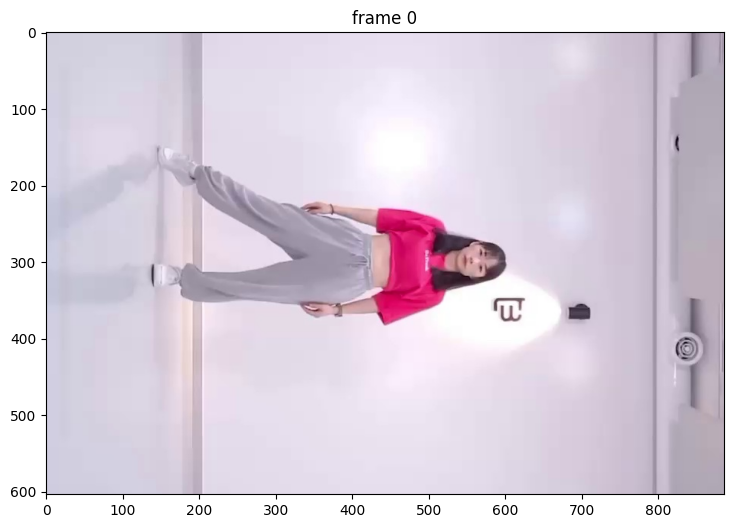

In [ ]:
original_video = cv2.VideoCapture("/content/drive/MyDrive/capston/SuperShy.mp4")
fps = original_video.get(cv2.CAP_PROP_FPS)

# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/content/drive/MyDrive/capston/SuperShy_frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

# 파트 나누기

/content/sam2/sam2/sam2_video_predictor.py:786: UserWarning: /content/sam2/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


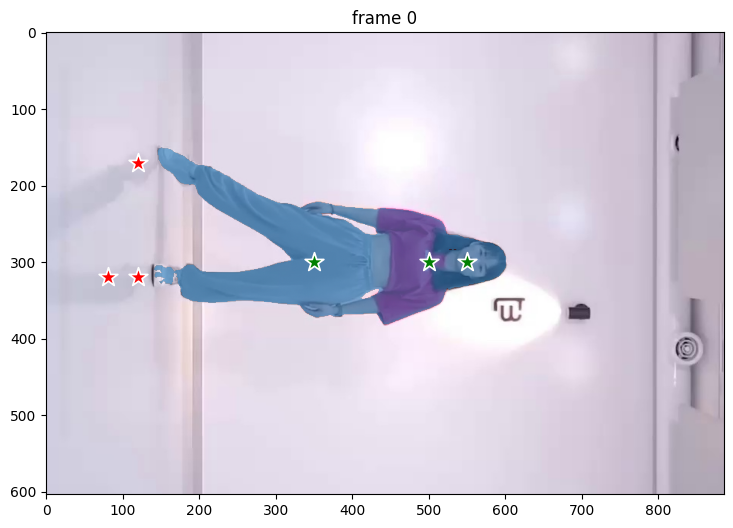

In [ ]:
# 전신
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points_0 = np.array([[500, 300], [350, 300], [80, 320], [120, 320], [120, 170], [550, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels_0 = np.array([1, 1, 0, 0, 0, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_0,
    labels=labels_0,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points_0, labels_0, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

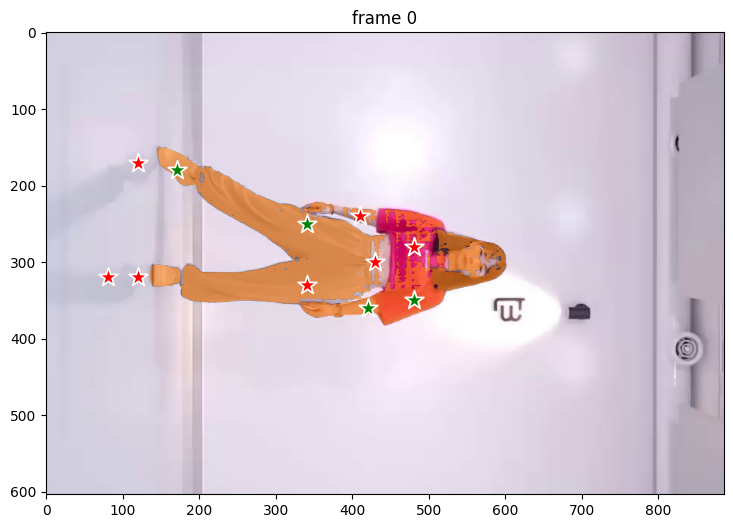

In [ ]:
# 오른팔, 왼다리
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points_1 = np.array([[170, 180], [410, 240],[430, 300], [340, 330], [420, 360], [480, 350], [340, 250], [480, 280], [80, 320], [120, 320], [120, 170]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels_1 = np.array([1, 0, 0, 0, 1, 1, 1, 0,0,0,0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_1,
    labels=labels_1,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points_1, labels_1, plt.gca())
show_mask((out_mask_logits[1] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[1])

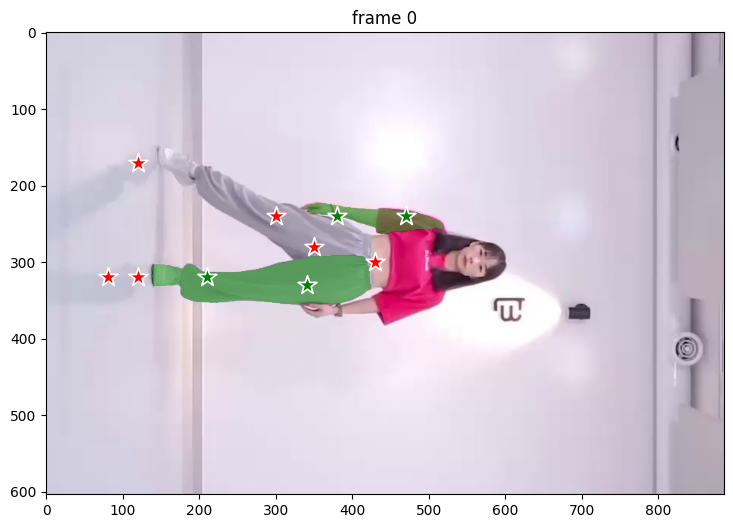

In [ ]:
# 왼팔, 오른다리
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 2  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points_2 = np.array([[470, 240], [380, 240], [350, 280], [300, 240],[430, 300], [340, 330], [210, 320], [80, 320], [120, 320], [120, 170]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels_2 = np.array([1, 1, 0, 0, 0, 1, 1,0,0,0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_2,
    labels=labels_2,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points_2, labels_2, plt.gca())
show_mask((out_mask_logits[2] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[2])

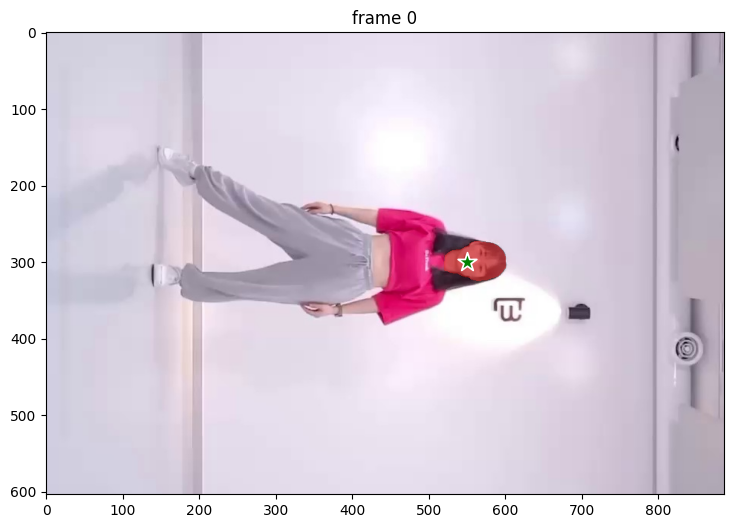

In [ ]:
# 머리
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 3  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points_3 = np.array([[550, 300]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels_3 = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points_3,
    labels=labels_3,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points_3, labels_3, plt.gca())
show_mask((out_mask_logits[3] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[3])

# 프레임 세그먼트

propagate in video: 100%|██████████| 2001/2001 [03:27<00:00,  9.62it/s]
<ipython-input-95-1413677662>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


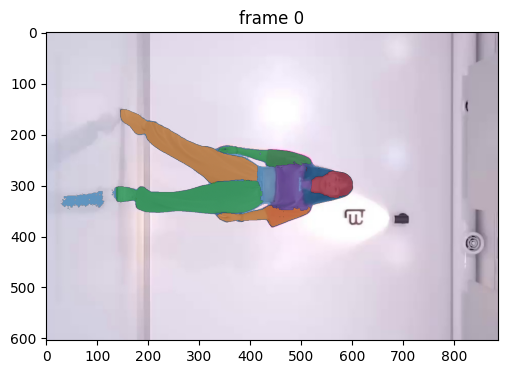

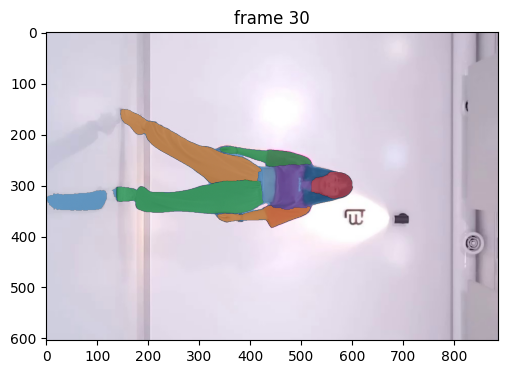

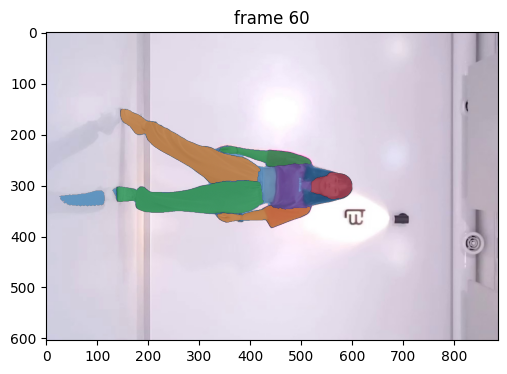

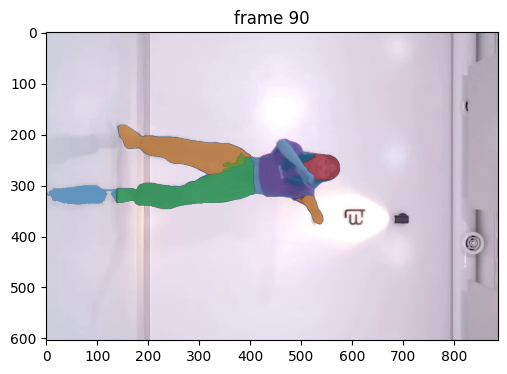

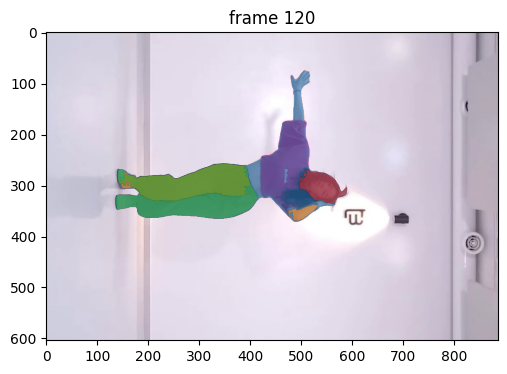

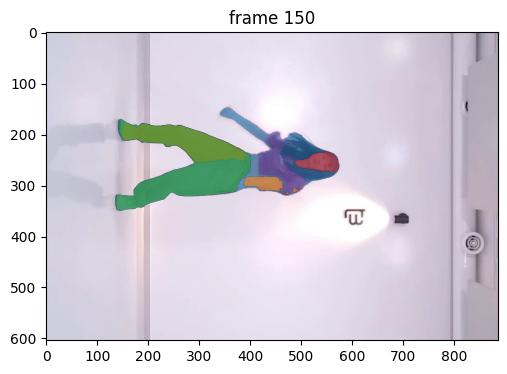

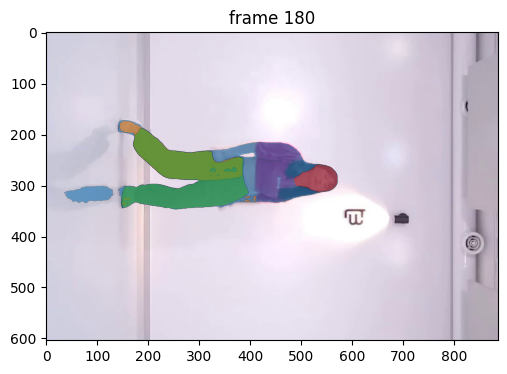

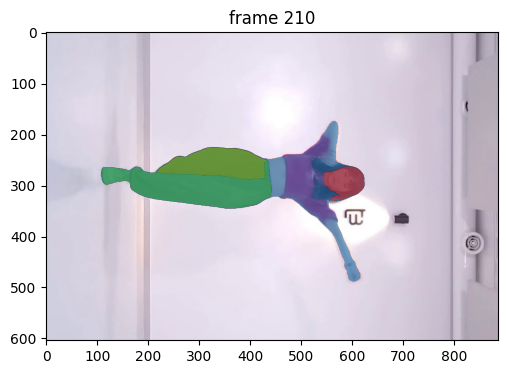

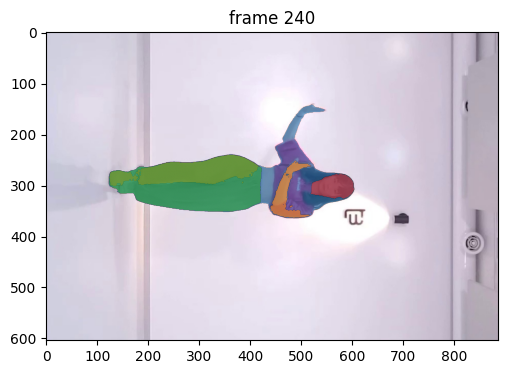

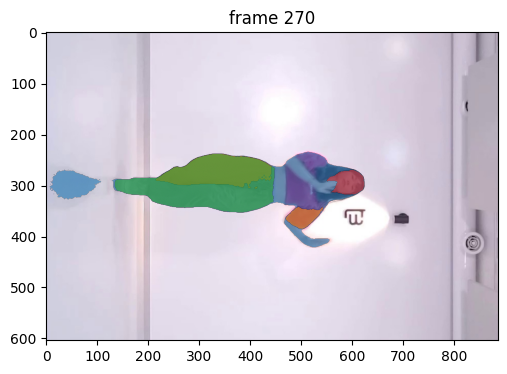

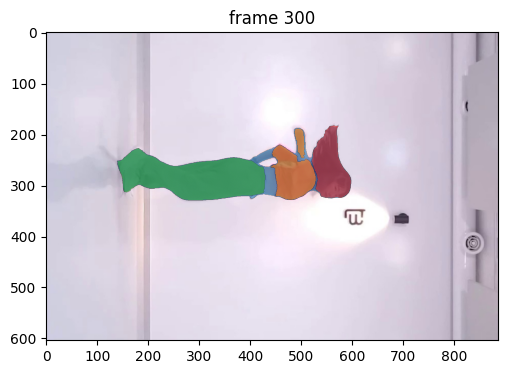

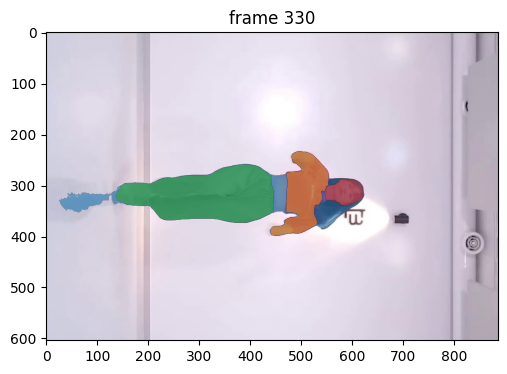

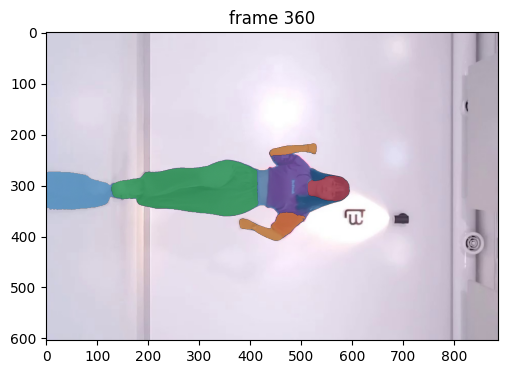

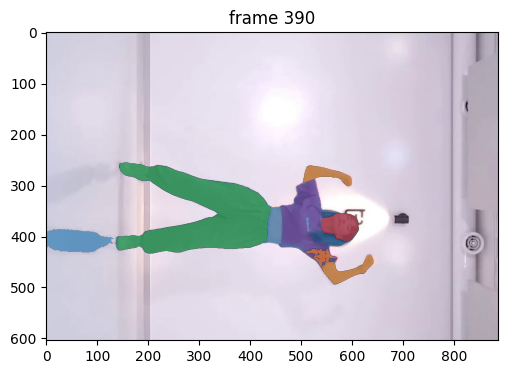

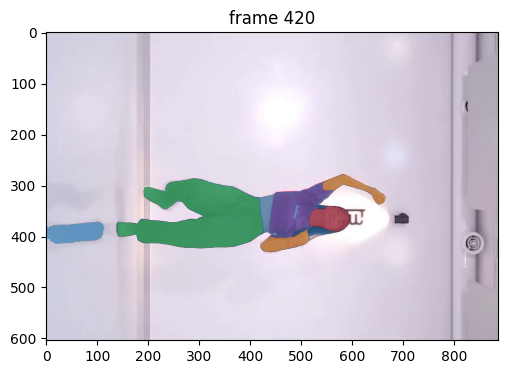

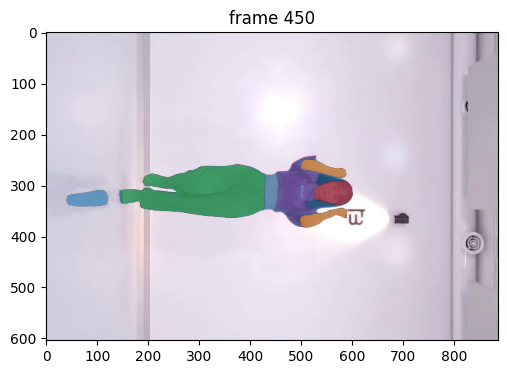

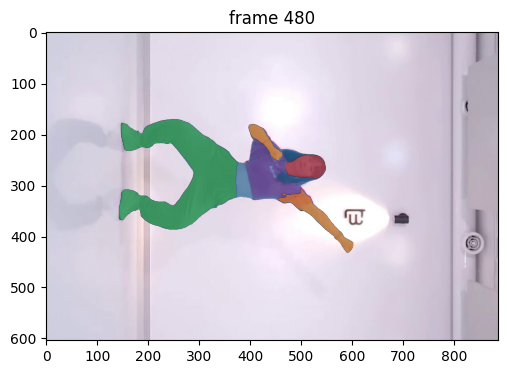

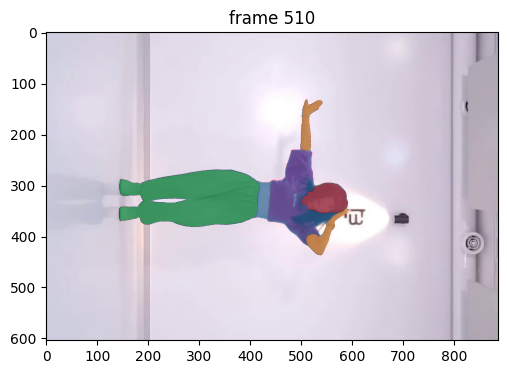

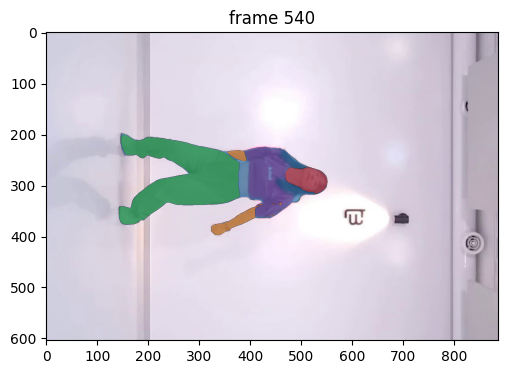

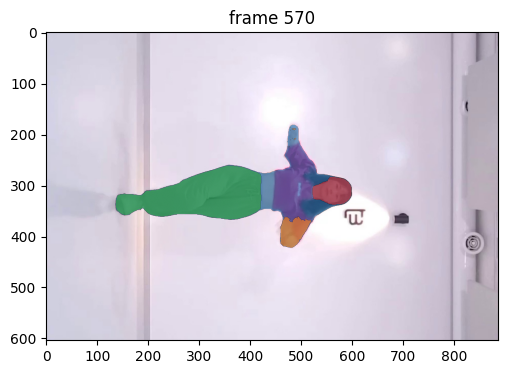

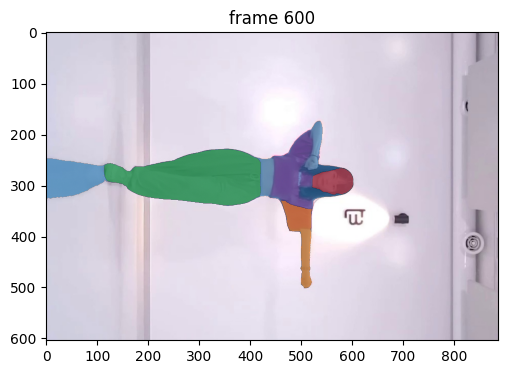

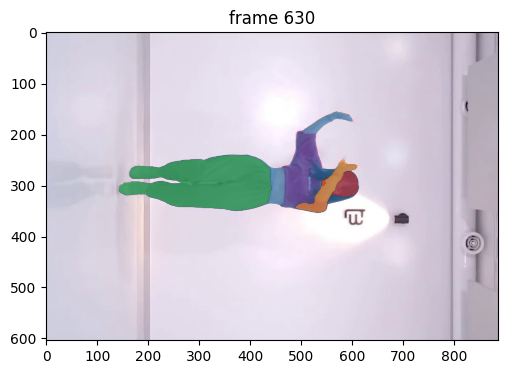

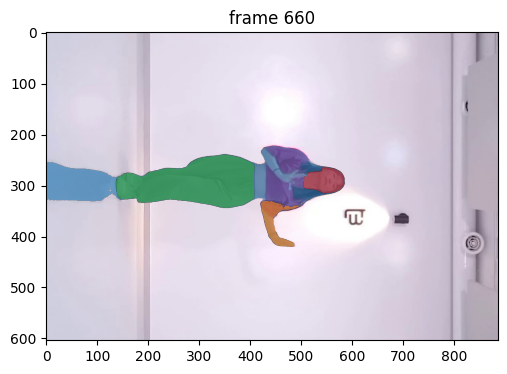

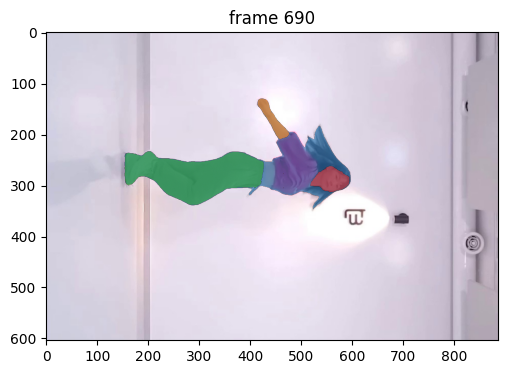

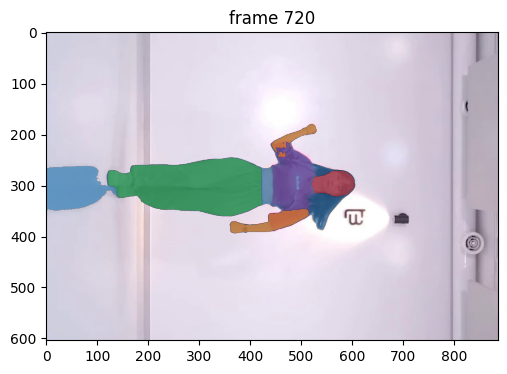

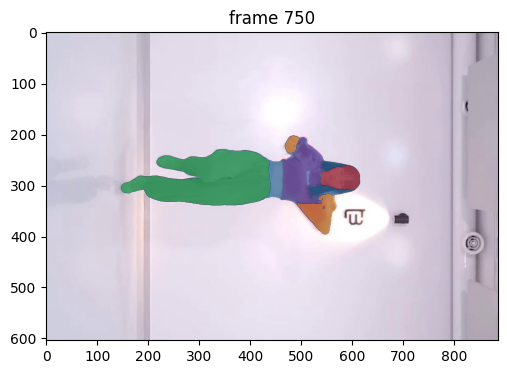

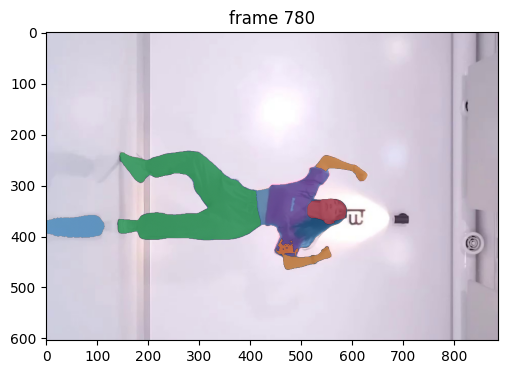

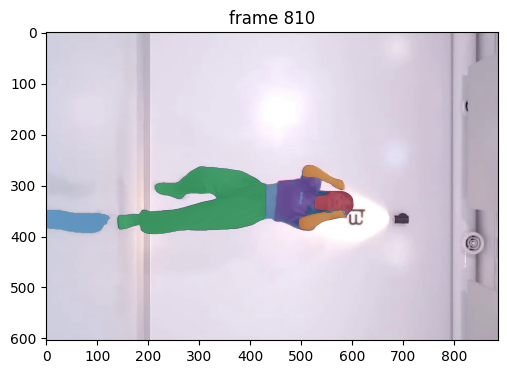

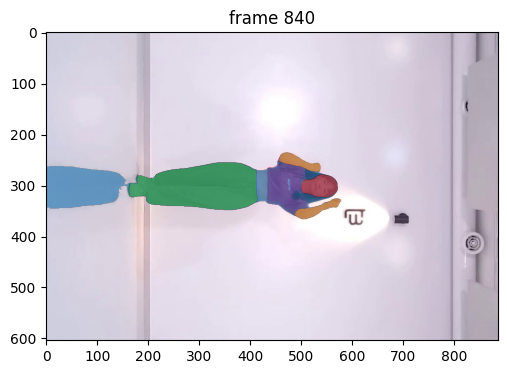

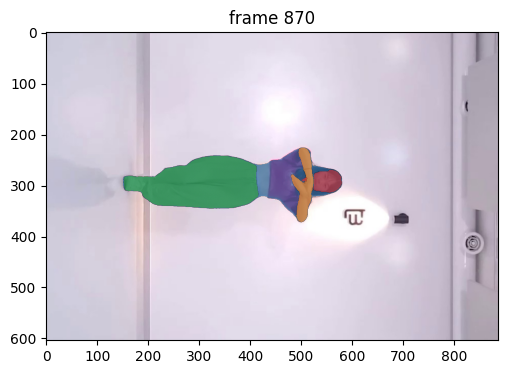

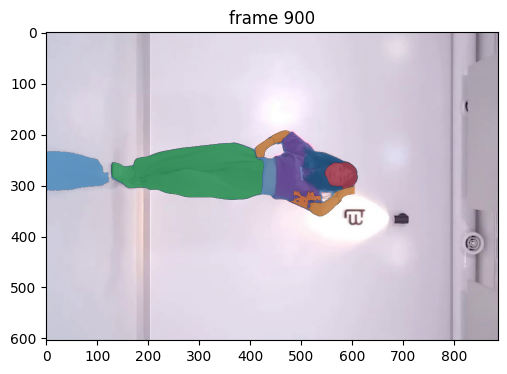

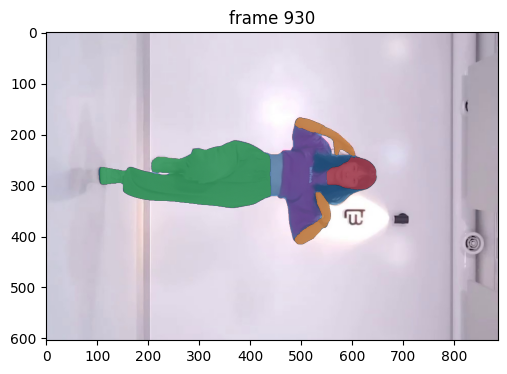

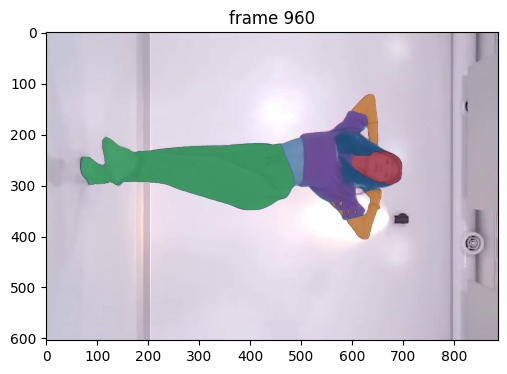

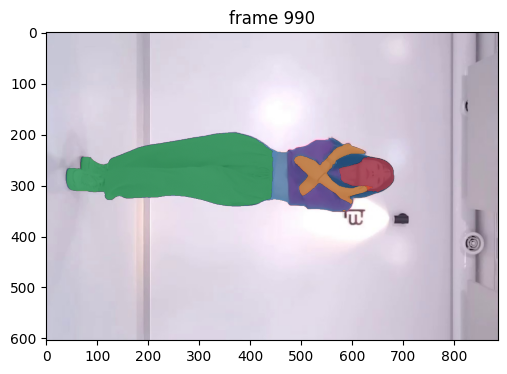

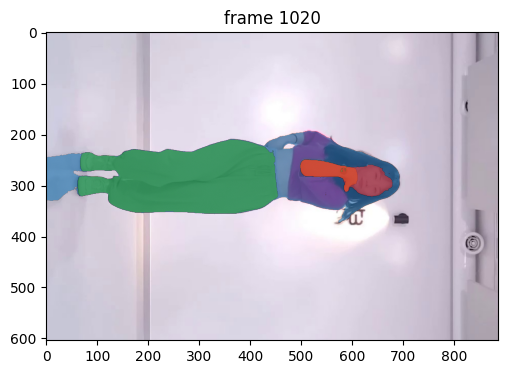

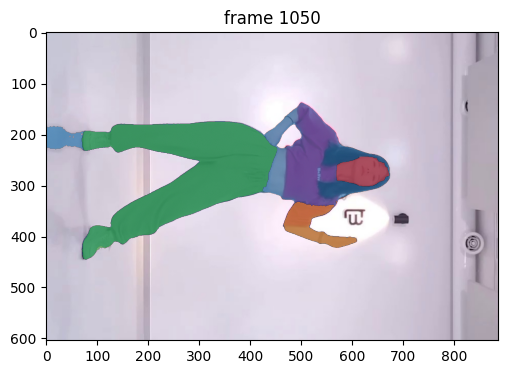

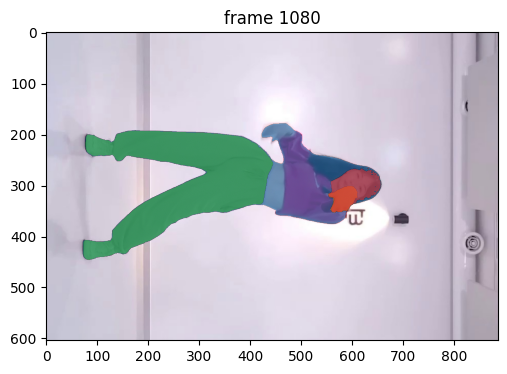

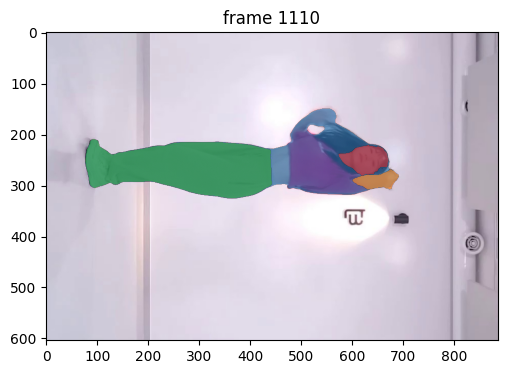

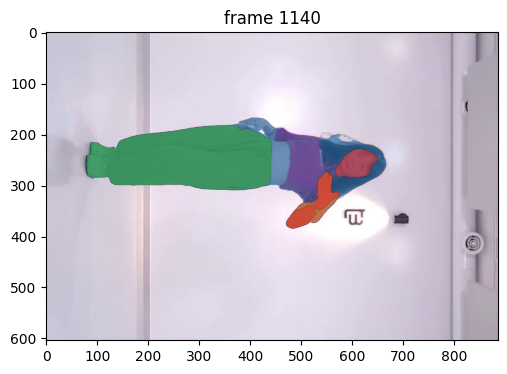

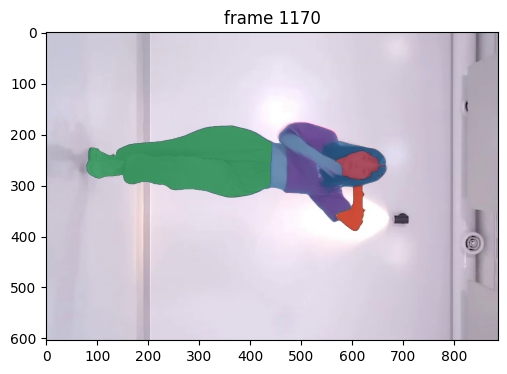

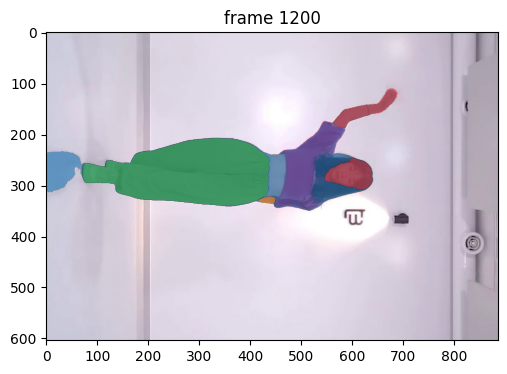

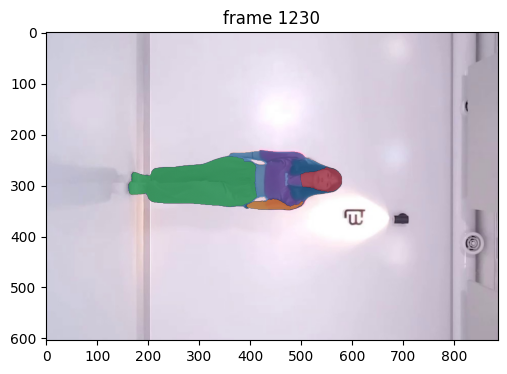

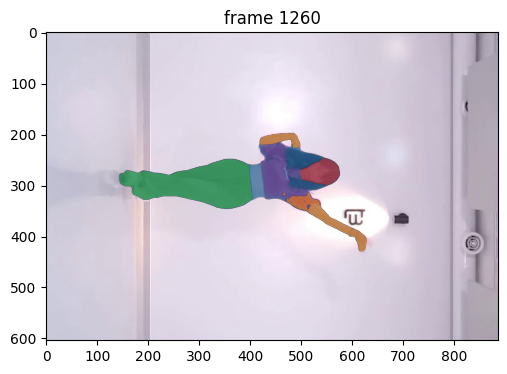

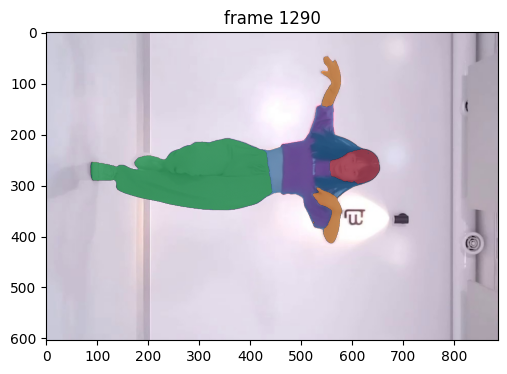

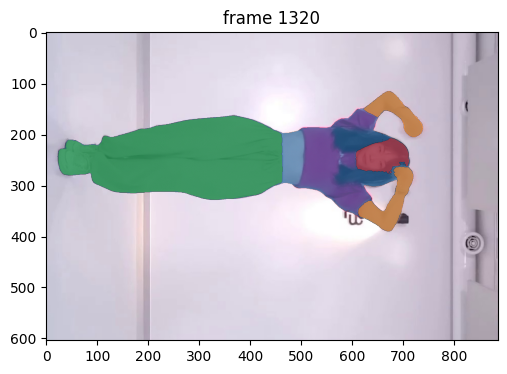

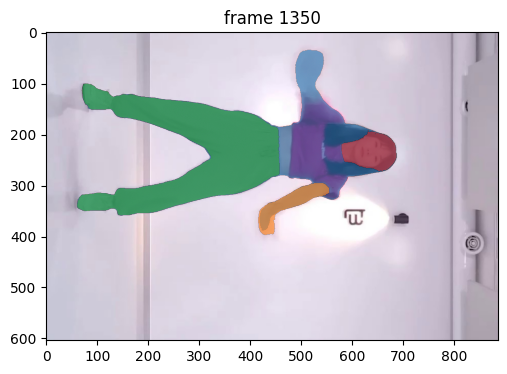

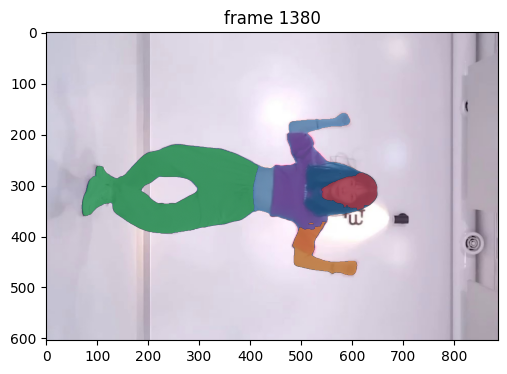

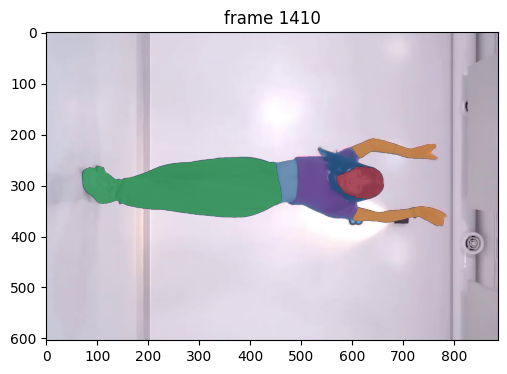

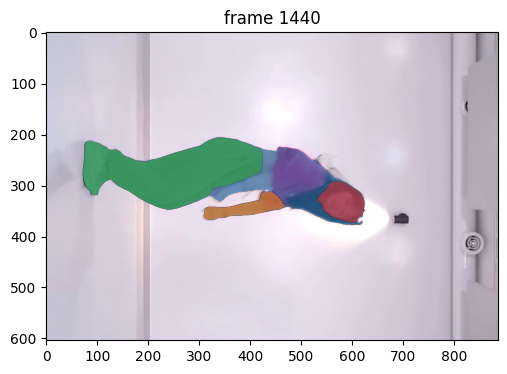

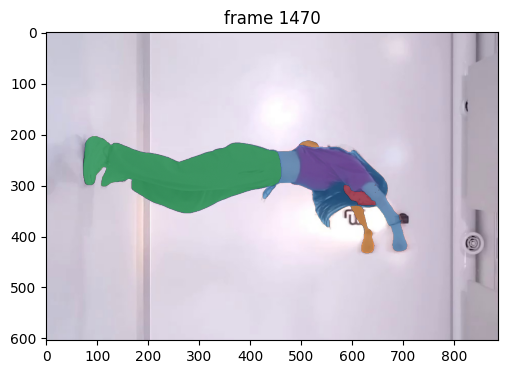

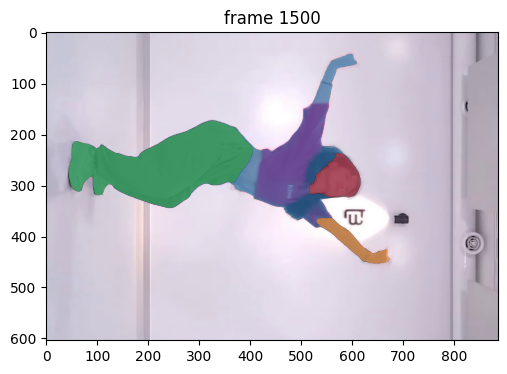

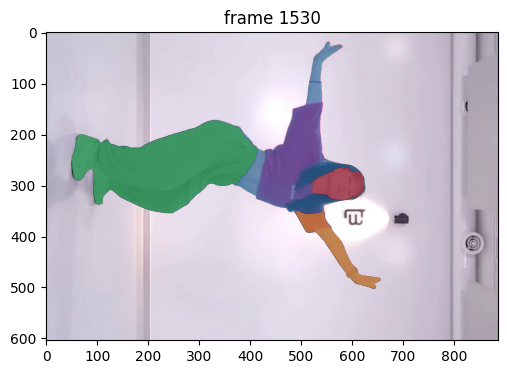

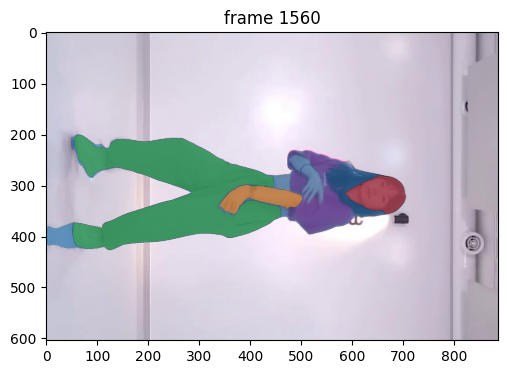

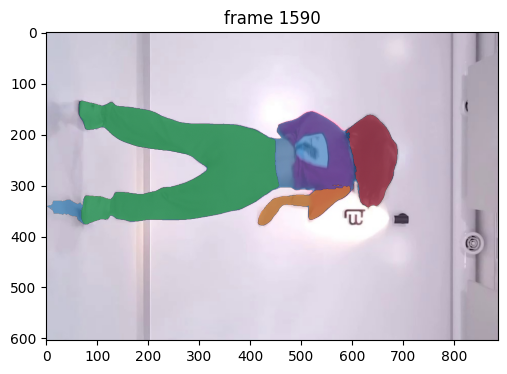

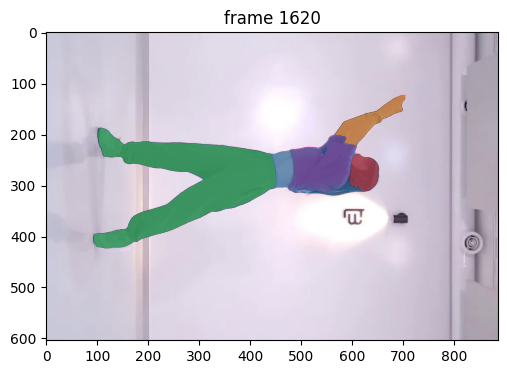

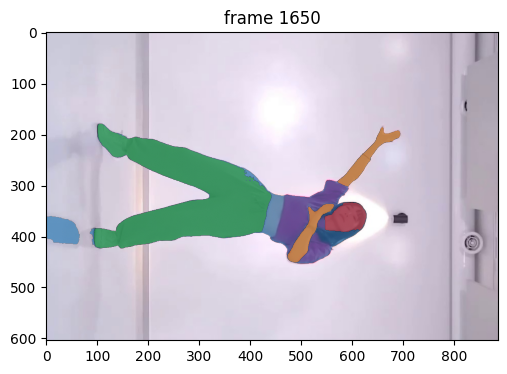

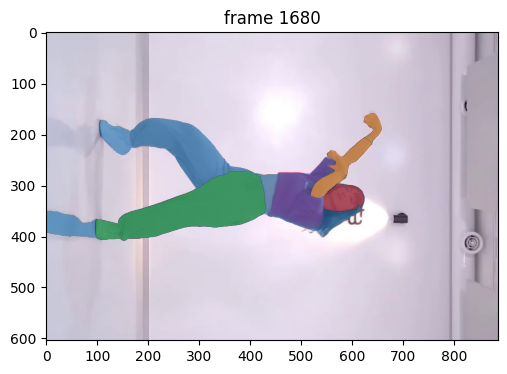

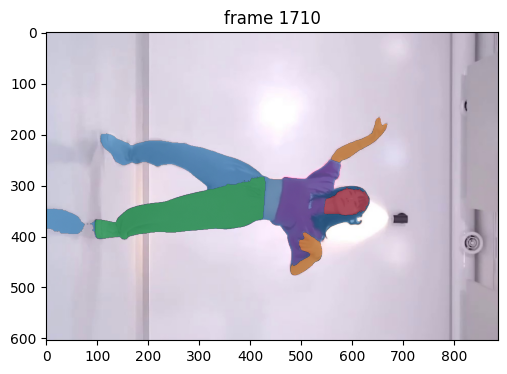

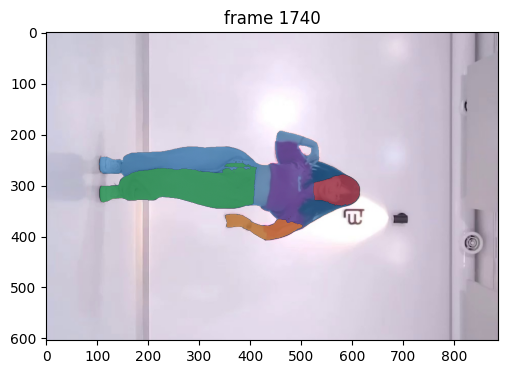

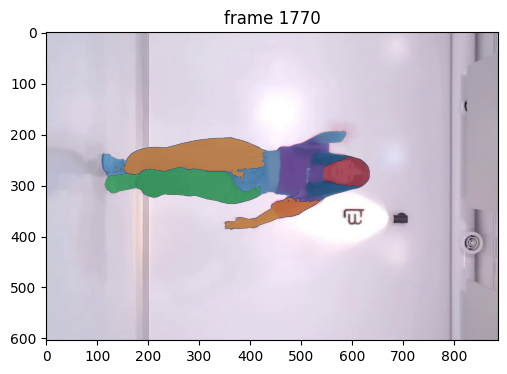

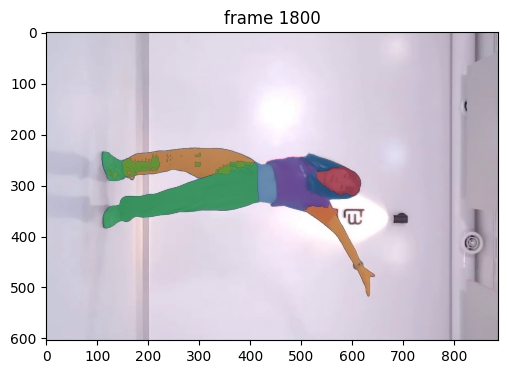

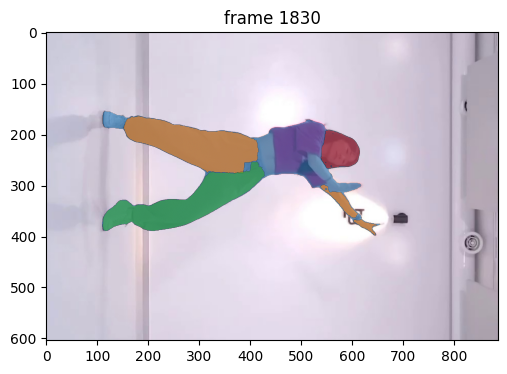

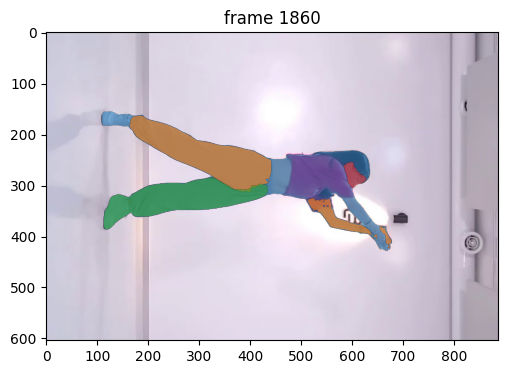

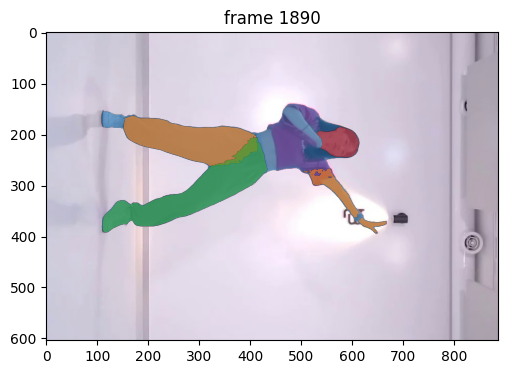

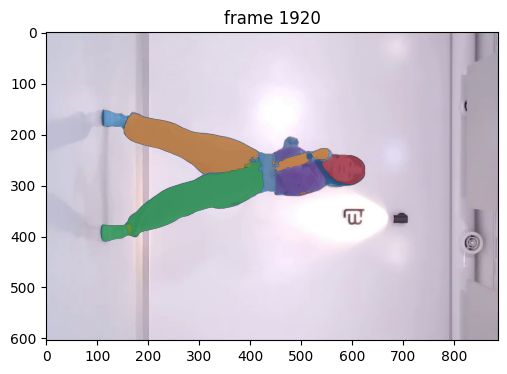

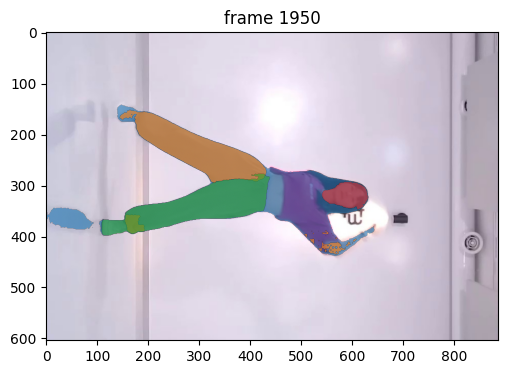

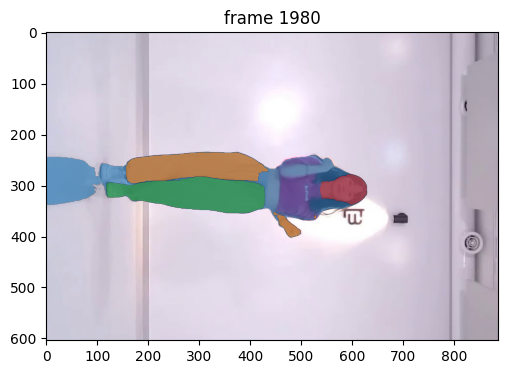

In [ ]:
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
'''
import pickle

# 세그멘트 결과 저장
with open("/content/drive/MyDrive/capston/video_segments.pkl", "wb") as f:
    pickle.dump(video_segments, f)
'''

In [ ]:
'''
# 세그멘트 결과 불러오기
with open("/content/drive/MyDrive/capston/video_segments.pkl", "rb") as f:
    video_segments = pickle.load(f)
'''

# 비디오 저장

In [ ]:
#############################################################
################ save segmentation video ################
#############################################################

## 동영상 원본 fps
# 동영상 파일 경로
video_path = "/content/drive/MyDrive/capston/SuperShy.mp4"

# 비디오 캡처 객체 생성
cap = cv2.VideoCapture(video_path)

if cap.isOpened():
    # FPS 가져오기
    fps = cap.get(cv2.CAP_PROP_FPS)
    print(f"FPS: {fps}")
else:
    print("동영상을 열 수 없습니다.")

# 캡처 객체 해제
cap.release()


FPS: 30.043072505384064


In [ ]:
'''
# 비디오 저장 경로와 설정
output_video_path = "/content/drive/MyDrive/capston/SuperShy_segmented.mp4"
frame_size = None  # 프레임 크기 (자동 설정)

for frame_idx, frame_name in enumerate(frame_names):
    # 원본 프레임 불러오기
    frame = np.array(Image.open(os.path.join(video_dir, frame_name)))

    # 첫 번째 프레임에서 비디오 크기 설정
    if frame_size is None:
        frame_size = (frame.shape[1], frame.shape[0])  # (width, height)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    # 세그멘테이션 결과 시각화
    overlay_frame = frame.copy()
    if frame_idx in video_segments:
        for out_obj_id, out_mask in video_segments[frame_idx].items():
            # 배치 차원 제거
            if out_mask.ndim == 3 and out_mask.shape[0] == 1:
                out_mask = np.squeeze(out_mask, axis=0)  # (1, H, W) → (H, W)

            # 마스크를 컬러로 변환
            colored_mask = np.zeros_like(frame, dtype=np.uint8)
            mask_indices = out_mask > 0
            colored_mask[mask_indices] = [255, 255, 255]  # 흰색 (RGB)

            # 투명도 설정
            alpha = 0.5
            overlay_frame = cv2.addWeighted(overlay_frame, 1 - alpha, colored_mask, alpha, 0)

    # 비디오에 프레임 추가
    video_writer.write(cv2.cvtColor(overlay_frame, cv2.COLOR_RGB2BGR))

# 비디오 작성기 종료
video_writer.release()
print(f"비디오 저장 완료: {output_video_path}")
'''

비디오 저장 완료: /content/drive/MyDrive/캡스톤/SuperShy_segemented3.mp4


# 외곽선 그리기

In [ ]:
# 외곽선 시각화 함수
def draw_segmentation_with_contours(image, mask, color=(255, 0, 0), thickness=2):
    """
    이미지에 마스크 외곽선을 추가하는 함수.
    """
    image = image.copy()
    mask = mask.astype(np.uint8)  # 마스크를 이진화 (0과 1로만 구성)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(image, contours, -1, color, thickness)  # 외곽선 그리기
    return image


In [ ]:
# 네온 효과 함수
def draw_neon_contours(image, mask, neon_color=(255, 0, 255), thickness=3, blur_size=21, glow_strength=3):
    """
    네온 효과를 외곽선에 적용하는 함수.
    Parameters:
        image (numpy.ndarray): 입력 이미지
        mask (numpy.ndarray): 이진화된 마스크 (0과 1로만 구성)
        neon_color (tuple): 네온 색상 (B, G, R)
        thickness (int): 외곽선 두께
        blur_size (int): 흐림 효과의 강도
        glow_strength (int): 흐림을 여러 번 반복해 네온 효과 강화
    """
    output = np.zeros_like(image)
    mask = mask.astype(np.uint8)

    # 외곽선 그리기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(output, contours, -1, neon_color, thickness, lineType=cv2.LINE_AA)

    # 네온 빛 흐림 효과 반복 적용
    neon_glow = np.zeros_like(output)
    for _ in range(glow_strength):
        output = cv2.GaussianBlur(output, (blur_size, blur_size), 0)
        neon_glow = cv2.addWeighted(neon_glow, 1.0, output, 0.5, 0)

    # 최종 네온 효과와 이미지 합성
    result = cv2.addWeighted(image, 1.0, neon_glow, 0.6, 0)
    cv2.drawContours(result, contours, -1, neon_color, thickness, lineType=cv2.LINE_AA)

    return result


In [ ]:
# ───── 경로 설정 ─────
video_path   = "/content/drive/MyDrive/capston/SuperShy.mp4"
frames_dir   = "/content/drive/MyDrive/capston/frames_rgba"          # PNG 시퀀스 저장 폴더
os.makedirs(frames_dir, exist_ok=True)

cap  = cv2.VideoCapture(video_path)
fps  = cap.get(cv2.CAP_PROP_FPS)
w    = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h    = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
nfrm = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for idx in range(nfrm):
    ok, frame = cap.read()
    if not ok:
        break

    overlay = np.zeros((h, w, 3), np.uint8)

    if idx in video_segments:                     # ← 기존 로직 유지
        for obj_id, m in video_segments[idx].items():
            mask = m.squeeze()
            overlay = draw_neon_contours(
                overlay, mask, neon_color=(255, 0, 255), thickness=2
            )

    # ─── RGB → RGBA (알파: 외곽선 있는 곳만 255) ───
    alpha = np.where(overlay.sum(axis=2) > 0, 255, 0).astype(np.uint8)
    rgba  = np.dstack([overlay, alpha])           # (H,W,4)

    # PIL로 저장 (RGBA PNG)
    Image.fromarray(rgba).save(
        os.path.join(frames_dir, f"frame_{idx:05d}.png")
    )

cap.release()
print("✓ PNG 시퀀스 저장 완료")

✓ PNG 시퀀스 저장 완료


In [ ]:
# 30 fps 예시, 필요 시 -framerate 값을 fps로 맞춰준다
!ffmpeg -framerate 30 \
       -i "/content/drive/MyDrive/capston/frames_rgba/frame_%05d.png" \
       -c:v libvpx -pix_fmt yuva420p -auto-alt-ref 0 \
       -b:v 4M -metadata:s:v:0 alpha_mode="1" \
       "/content/drive/MyDrive/capston/SuperShy_contour.webm"


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
!ffmpeg -i "/content/drive/MyDrive/capston/SuperShy_contour.webm" \
-vf "chromakey=0x000000:0.10:0.00,format=yuva420p" \
-c:v libvpx \
-pix_fmt yuva420p \
-auto-alt-ref 0 \
-b:v 4M \
"/content/drive/MyDrive/capston/SuperShy_contour_alpha.webm"


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab